In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# flags
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file,
                    input_height=108,
                    input_width=None,
                    resize_height=64,
                    resize_width=64,
                    crop=True,
                    grayscale=False) for sample_file in sample_files]

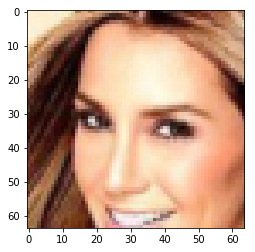

In [4]:
plt.imshow((sample[0] + 1.0)/2.0)
plt.show()

In [5]:
v = np.reshape(sample, (64, 64*64*3))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (64, 12288)


In [ ]:
# this is compressed sensing setting
m = 1000
A = np.random.randn(n, m).astype('float32')
A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
y = np.dot(v, A) 

# this is full image included setting
# m = n 
print('number of measurements = {}'.format(m))
# y = v

In [ ]:
# y_placeholder = tf.placeholder(tf.float32,[None,m])

# this loss is when we are doing compressed sensing
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 

# this loss is when we are taking image as measurement
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 

In [ ]:
y.shape

In [ ]:
#grad = tf.gradients(our_loss, dcgan.z)
#z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))
count = 0

errs = []
    
    
with tf.Session() as sess:
    
    print(tf.global_variables())
    
    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)
    
    

    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")
    
    dcgan.z.initializer.run()
    
    y_placeholder = tf.placeholder(tf.float32,[None,m])
    
    # -----------------------------------
    # use this if we are not using A
    # our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 
    # use this if we are using A
    our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
    # -----------------------------------
    
    z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  
    
#     show_all_variables()
    
    
    opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
    beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
    beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]
    
    sess.run(opt_initializers)
    sess.run(beta1_initializers)
    sess.run(beta2_initializers)

    
    for i in range(1000): # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
        count += 1
        print(closs)
        errs.append(closs)
        #z_0 = z_0 - rate*a[0]
    

In [ ]:
chosen_image = 19

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow((sample[chosen_image]+1.0)/2)

ax2 = fig.add_subplot(122)
ax2.imshow((b[chosen_image]+1.0)/2)
plt.show()

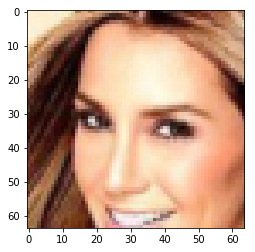

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

121.453
iteration 285
121.085
iteration 286
120.384
iteration 287
119.864
iteration 288
119.224
iteration 289
118.761
iteration 290
118.588
iteration 291
118.321
iteration 292
117.055
iteration 293
117.221
iteration 294
116.047
iteration 295
115.647
iteration 296
115.48
iteration 297
114.741
iteration 298
114.582
iteration 299
114.488
iteration 300
113.738
iteration 301
113.365
iteration 302
113.651
iteration 303
113.074
iteration 304
112.456
iteration 305
112.304
iteration 306
112.462
iteration 307
111.234
iteration 308
111.926
iteration 309
112.95
iteration 310
112.732
iteration 311
110.095
iteration 312
113.329
iteration 313
110.937
iteration 314
113.479
iteration 315
113.207
iteration 316
110.622
iteration 317
109.904
iteration 318
111.475
iteration 319
110.94
iteration 320
109.165
iteration 321
109.04
iteration 322
109.294
iteration 323
108.803
iteration 324
107.673
iteration 325
107.421
iteration 326
107.078
iteration 327
107.581
iteration 328
106.105
iteration 329
105.996
iterat

47.8605
iteration 659
47.2047
iteration 660
46.9848
iteration 661
46.2841
iteration 662
46.2209
iteration 663
46.6574
iteration 664
45.5386
iteration 665
45.658
iteration 666
45.5372
iteration 667
45.0914
iteration 668
45.021
iteration 669
44.5416
iteration 670
44.73
iteration 671
44.5663
iteration 672
44.3647
iteration 673
44.2525
iteration 674
43.8163
iteration 675
44.0724
iteration 676
43.4659
iteration 677
43.6365
iteration 678
43.8952
iteration 679
43.5039
iteration 680
44.1725
iteration 681
43.4418
iteration 682
43.2822
iteration 683
43.7018
iteration 684
42.6439
iteration 685
43.3682
iteration 686
42.9543
iteration 687
42.3864
iteration 688
42.9977
iteration 689
42.1698
iteration 690
42.5471
iteration 691
42.6404
iteration 692
42.4526
iteration 693
42.7101
iteration 694
43.3315
iteration 695
43.0048
iteration 696
42.8212
iteration 697
42.7235
iteration 698
41.6235
iteration 699
41.7648
iteration 700
42.346
iteration 701
41.4095
iteration 702
41.6
iteration 703
42.9834
iteration 

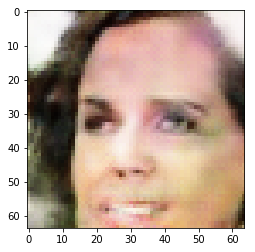

number of measurements = 100
iteration 0
1303.61
iteration 1
1202.22
iteration 2
1059.49
iteration 3
955.599
iteration 4
894.553
iteration 5
842.694
iteration 6
800.758
iteration 7
764.712
iteration 8
735.571
iteration 9
713.872
iteration 10
692.521
iteration 11
670.149
iteration 12
651.893
iteration 13
637.416
iteration 14
623.063
iteration 15
609.22
iteration 16
595.37
iteration 17
582.785
iteration 18
570.782
iteration 19
558.656
iteration 20
548.792
iteration 21
538.96
iteration 22
529.708
iteration 23
521.555
iteration 24
512.496
iteration 25
502.419
iteration 26
492.152
iteration 27
483.764
iteration 28
475.994
iteration 29
468.424
iteration 30
460.961
iteration 31
453.407
iteration 32
445.611
iteration 33
438.302
iteration 34
431.497
iteration 35
425.128
iteration 36
418.835
iteration 37
412.849
iteration 38
407.658
iteration 39
402.671
iteration 40
397.68
iteration 41
393.033
iteration 42
387.71
iteration 43
382.773
iteration 44
378.491
iteration 45
374.355
iteration 46
370.448

122.088
iteration 379
122.325
iteration 380
121.33
iteration 381
121.724
iteration 382
121.361
iteration 383
120.859
iteration 384
120.042
iteration 385
120.549
iteration 386
119.968
iteration 387
119.479
iteration 388
119.838
iteration 389
119.607
iteration 390
119.86
iteration 391
118.154
iteration 392
119.348
iteration 393
119.718
iteration 394
120.016
iteration 395
118.796
iteration 396
118.638
iteration 397
118.166
iteration 398
117.603
iteration 399
117.686
iteration 400
117.888
iteration 401
116.668
iteration 402
117.138
iteration 403
116.203
iteration 404
116.926
iteration 405
116.484
iteration 406
116.461
iteration 407
117.269
iteration 408
116.833
iteration 409
117.458
iteration 410
116.615
iteration 411
116.022
iteration 412
116.552
iteration 413
115.644
iteration 414
116.171
iteration 415
116.435
iteration 416
115.673
iteration 417
116.455
iteration 418
115.574
iteration 419
115.556
iteration 420
114.029
iteration 421
114.612
iteration 422
113.787
iteration 423
114.439
iter

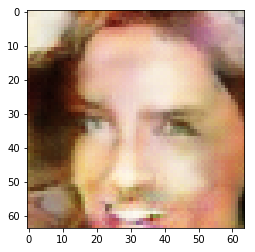

number of measurements = 200
iteration 0
748.561
iteration 1
905.863
iteration 2
729.104
iteration 3
684.64
iteration 4
671.932
iteration 5
631.401
iteration 6
596.429
iteration 7
583.309
iteration 8
572.961
iteration 9
559.908
iteration 10
544.172
iteration 11
531.021
iteration 12
519.709
iteration 13
508.726
iteration 14
499.575
iteration 15
491.603
iteration 16
483.33
iteration 17
474.372
iteration 18
465.626
iteration 19
458.656
iteration 20
453.571
iteration 21
448.167
iteration 22
441.826
iteration 23
435.779
iteration 24
430.92
iteration 25
425.974
iteration 26
421.273
iteration 27
416.602
iteration 28
411.996
iteration 29
407.746
iteration 30
403.134
iteration 31
399.252
iteration 32
395.335
iteration 33
391.399
iteration 34
388.01
iteration 35
384.678
iteration 36
381.558
iteration 37
378.328
iteration 38
374.834
iteration 39
371.741
iteration 40
368.759
iteration 41
366.019
iteration 42
363.262
iteration 43
360.473
iteration 44
357.932
iteration 45
355.367
iteration 46
352.96

189.821
iteration 378
189.28
iteration 379
189.049
iteration 380
189.093
iteration 381
189.456
iteration 382
189.504
iteration 383
188.991
iteration 384
188.924
iteration 385
188.813
iteration 386
188.42
iteration 387
188.142
iteration 388
188.39
iteration 389
187.696
iteration 390
188.138
iteration 391
187.573
iteration 392
187.923
iteration 393
187.806
iteration 394
187.855
iteration 395
187.567
iteration 396
187.356
iteration 397
187.147
iteration 398
187.114
iteration 399
186.985
iteration 400
186.926
iteration 401
186.738
iteration 402
186.177
iteration 403
186.617
iteration 404
186.146
iteration 405
185.802
iteration 406
186.127
iteration 407
185.486
iteration 408
185.754
iteration 409
185.632
iteration 410
185.164
iteration 411
185.95
iteration 412
185.417
iteration 413
185.715
iteration 414
186.184
iteration 415
186.628
iteration 416
187.068
iteration 417
187.125
iteration 418
186.478
iteration 419
185.272
iteration 420
186.024
iteration 421
186.255
iteration 422
186.257
iterat

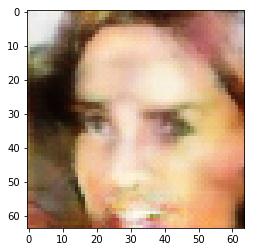

number of measurements = 500
iteration 0
497.258
iteration 1
783.497
iteration 2
584.652
iteration 3
572.581
iteration 4
558.624
iteration 5
529.109
iteration 6
507.173
iteration 7
492.272
iteration 8
484.961
iteration 9
473.946
iteration 10
461.347
iteration 11
450.034
iteration 12
442.393
iteration 13
436.471
iteration 14
428.828
iteration 15
418.986
iteration 16
412.288
iteration 17
407.649
iteration 18
402.98
iteration 19
398.964
iteration 20
394.7
iteration 21
389.947
iteration 22
385.852
iteration 23
381.943
iteration 24
378.125
iteration 25
375.117
iteration 26
371.799
iteration 27
368.582
iteration 28
365.745
iteration 29
363.345
iteration 30
360.777
iteration 31
358.195
iteration 32
355.914
iteration 33
353.246
iteration 34
351.126
iteration 35
349.3
iteration 36
347.084
iteration 37
344.769
iteration 38
343.066
iteration 39
341.499
iteration 40
339.382
iteration 41
337.88
iteration 42
336.32
iteration 43
334.701
iteration 44
333.256
iteration 45
331.586
iteration 46
330.244
i

245.825
iteration 379
245.11
iteration 380
244.643
iteration 381
244.513
iteration 382
244.547
iteration 383
244.317
iteration 384
243.57
iteration 385
244.267
iteration 386
244.213
iteration 387
244.263
iteration 388
244.718
iteration 389
243.804
iteration 390
244.181
iteration 391
244.271
iteration 392
244.072
iteration 393
244.393
iteration 394
244.238
iteration 395
244.19
iteration 396
243.7
iteration 397
244.055
iteration 398
243.764
iteration 399
243.7
iteration 400
243.715
iteration 401
243.097
iteration 402
242.51
iteration 403
242.464
iteration 404
242.9
iteration 405
242.854
iteration 406
242.586
iteration 407
242.703
iteration 408
242.42
iteration 409
241.756
iteration 410
241.851
iteration 411
241.902
iteration 412
241.097
iteration 413
241.534
iteration 414
241.385
iteration 415
241.137
iteration 416
241.67
iteration 417
241.677
iteration 418
241.128
iteration 419
241.661
iteration 420
241.162
iteration 421
240.881
iteration 422
241.281
iteration 423
240.697
iteration 424


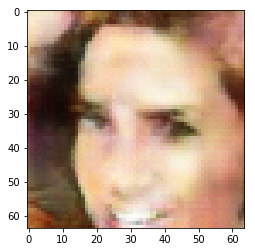

number of measurements = 1000
iteration 0
358.588
iteration 1
730.374
iteration 2
465.97
iteration 3
481.073
iteration 4
494.228
iteration 5
458.385
iteration 6
436.715
iteration 7
429.498
iteration 8
423.957
iteration 9
417.205
iteration 10
407.607
iteration 11
398.184
iteration 12
391.555
iteration 13
386.77
iteration 14
380.941
iteration 15
375.795
iteration 16
371.089
iteration 17
365.424
iteration 18
359.35
iteration 19
354.28
iteration 20
351.492
iteration 21
350.099
iteration 22
346.574
iteration 23
341.675
iteration 24
338.248
iteration 25
336.507
iteration 26
334.447
iteration 27
332.282
iteration 28
330.573
iteration 29
328.653
iteration 30
326.337
iteration 31
324.153
iteration 32
322.857
iteration 33
321.391
iteration 34
319.657
iteration 35
318.019
iteration 36
316.926
iteration 37
315.628
iteration 38
314.31
iteration 39
312.865
iteration 40
311.817
iteration 41
310.715
iteration 42
309.743
iteration 43
308.966
iteration 44
308.07
iteration 45
307.115
iteration 46
306.198

257.332
iteration 379
257.174
iteration 380
257.331
iteration 381
257.262
iteration 382
257.023
iteration 383
256.922
iteration 384
256.561
iteration 385
256.603
iteration 386
256.552
iteration 387
256.562
iteration 388
256.551
iteration 389
256.311
iteration 390
256.697
iteration 391
256.485
iteration 392
256.764
iteration 393
256.533
iteration 394
256.18
iteration 395
256.024
iteration 396
255.819
iteration 397
255.512
iteration 398
255.752
iteration 399
255.748
iteration 400
255.898
iteration 401
255.919
iteration 402
255.682
iteration 403
255.647
iteration 404
255.582
iteration 405
255.716
iteration 406
255.582
iteration 407
255.4
iteration 408
255.157
iteration 409
254.925
iteration 410
254.857
iteration 411
254.918
iteration 412
254.765
iteration 413
254.758
iteration 414
254.729
iteration 415
254.905
iteration 416
254.853
iteration 417
254.774
iteration 418
255.223
iteration 419
255.49
iteration 420
255.756
iteration 421
256.07
iteration 422
255.978
iteration 423
255.891
iterati

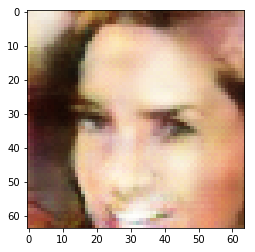

number of measurements = 2500
iteration 0
304.322
iteration 1
786.299
iteration 2
471.495
iteration 3
467.407
iteration 4
479.875
iteration 5
453.809
iteration 6
426.638
iteration 7
414.877
iteration 8
408.095
iteration 9
397.755
iteration 10
386.968
iteration 11
378.015
iteration 12
371.4
iteration 13
364.499
iteration 14
357.273
iteration 15
350.968
iteration 16
346.481
iteration 17
342.037
iteration 18
337.5
iteration 19
333.863
iteration 20
330.415
iteration 21
326.752
iteration 22
323.506
iteration 23
320.846
iteration 24
318.751
iteration 25
315.506
iteration 26
311.897
iteration 27
309.848
iteration 28
308.882
iteration 29
307.051
iteration 30
305.003
iteration 31
303.592
iteration 32
302.279
iteration 33
300.628
iteration 34
298.925
iteration 35
297.855
iteration 36
296.841
iteration 37
295.851
iteration 38
294.677
iteration 39
293.43
iteration 40
292.613
iteration 41
291.901
iteration 42
291.008
iteration 43
290.125
iteration 44
289.609
iteration 45
288.996
iteration 46
288.18

264.301
iteration 379
264.265
iteration 380
264.59
iteration 381
264.334
iteration 382
263.605
iteration 383
264.073
iteration 384
263.572
iteration 385
263.397
iteration 386
263.654
iteration 387
262.961
iteration 388
263.204
iteration 389
263.128
iteration 390
262.907
iteration 391
262.907
iteration 392
262.774
iteration 393
262.796
iteration 394
262.725
iteration 395
262.386
iteration 396
262.568
iteration 397
262.179
iteration 398
262.492
iteration 399
262.469
iteration 400
262.519
iteration 401
263.088
iteration 402
262.75
iteration 403
263.176
iteration 404
263.613
iteration 405
263.406
iteration 406
263.156
iteration 407
263.1
iteration 408
262.633
iteration 409
262.506
iteration 410
262.541
iteration 411
262.422
iteration 412
262.516
iteration 413
262.192
iteration 414
262.635
iteration 415
262.655
iteration 416
262.587
iteration 417
262.319
iteration 418
262.237
iteration 419
262.089
iteration 420
262.03
iteration 421
261.974
iteration 422
261.907
iteration 423
261.962
iterati

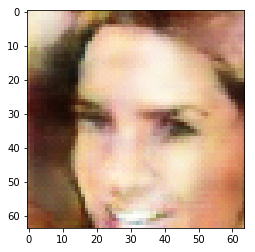

number of measurements = 5000
iteration 0
277.631
iteration 1
769.784
iteration 2
429.234
iteration 3
429.138
iteration 4
457.056
iteration 5
439.647
iteration 6
415.156
iteration 7
397.52
iteration 8
386.149
iteration 9
378.113
iteration 10
370.634
iteration 11
364.048
iteration 12
358.229
iteration 13
352.944
iteration 14
346.277
iteration 15
338.423
iteration 16
333.38
iteration 17
330.312
iteration 18
326.359
iteration 19
321.535
iteration 20
317.544
iteration 21
313.724
iteration 22
310.953
iteration 23
308.419
iteration 24
305.273
iteration 25
302.661
iteration 26
301.201
iteration 27
299.708
iteration 28
297.411
iteration 29
295.714
iteration 30
294.44
iteration 31
292.543
iteration 32
290.742
iteration 33
289.633
iteration 34
288.364
iteration 35
287.02
iteration 36
285.83
iteration 37
285.106
iteration 38
284.161
iteration 39
283.024
iteration 40
282.236
iteration 41
281.56
iteration 42
280.718
iteration 43
279.945
iteration 44
279.243
iteration 45
278.623
iteration 46
278.038

259.793
iteration 379
259.751
iteration 380
259.576
iteration 381
259.52
iteration 382
259.77
iteration 383
259.786
iteration 384
259.601
iteration 385
259.794
iteration 386
259.841
iteration 387
259.727
iteration 388
259.974
iteration 389
259.819
iteration 390
259.727
iteration 391
260.236
iteration 392
259.834
iteration 393
259.619
iteration 394
259.36
iteration 395
259.168
iteration 396
259.148
iteration 397
259.118
iteration 398
259.409
iteration 399
259.367
iteration 400
259.752
iteration 401
259.746
iteration 402
260.037
iteration 403
259.601
iteration 404
259.489
iteration 405
259.216
iteration 406
259.472
iteration 407
259.578
iteration 408
259.464
iteration 409
259.778
iteration 410
259.616
iteration 411
259.496
iteration 412
259.572
iteration 413
259.386
iteration 414
259.355
iteration 415
259.614
iteration 416
259.744
iteration 417
259.621
iteration 418
259.854
iteration 419
259.375
iteration 420
259.475
iteration 421
259.127
iteration 422
258.949
iteration 423
259.06
iterat

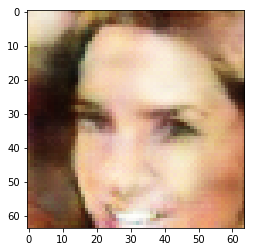

In [6]:
possible_ms = [50, 100, 200, 500, 1000, 2500, 5000]#, 7500, 10000]
num_iter = 750
compressed_images = []

plt.imshow((sample[0] + 1.0)/2.0)
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for m in possible_ms:
        A = np.random.randn(n, m).astype('float32')
        A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
        y = np.dot(v, A) 

        print('number of measurements = {}'.format(m))
        count = 0
        y_placeholder = tf.placeholder(tf.float32,[None,m])

        # -----------------------------------
        our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): 
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            count += 1
            print(closs)
        plt.imshow((b[0] + 1.0)/2.0)
        compressed_images.append(b)
        plt.show()

    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


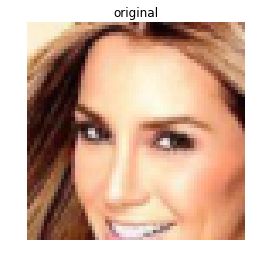

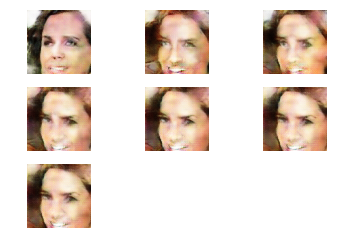

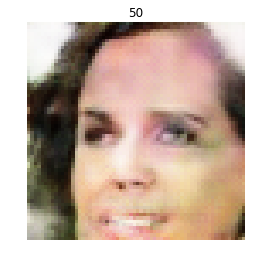

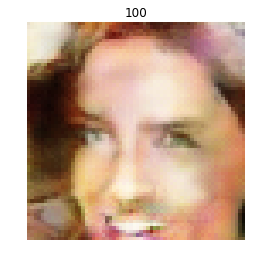

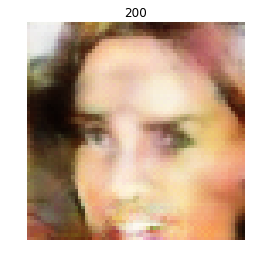

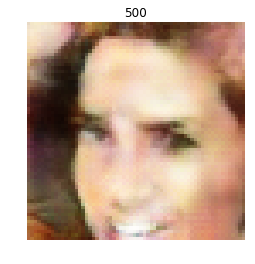

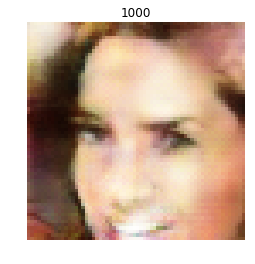

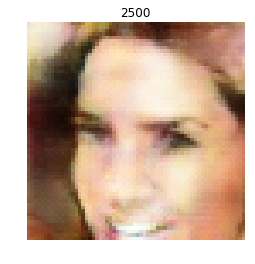

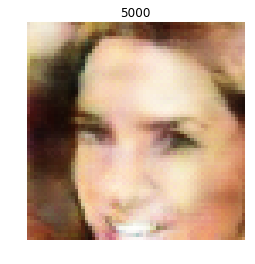

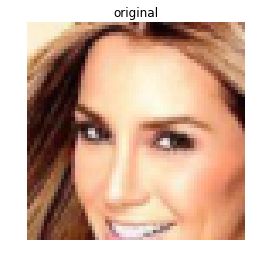

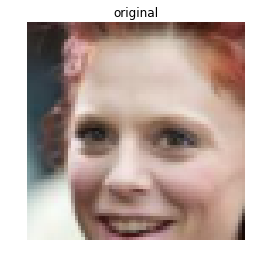

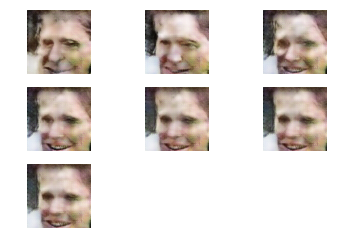

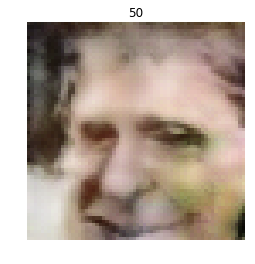

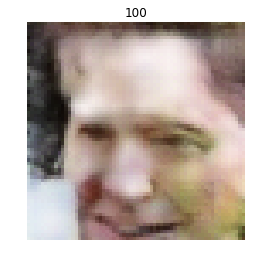

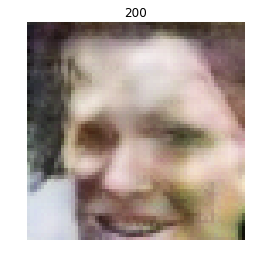

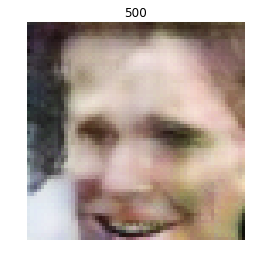

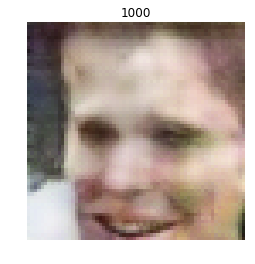

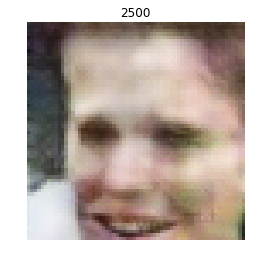

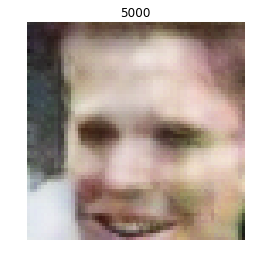

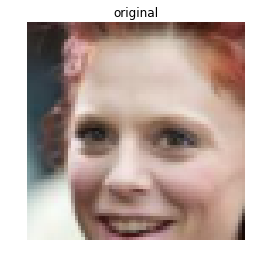

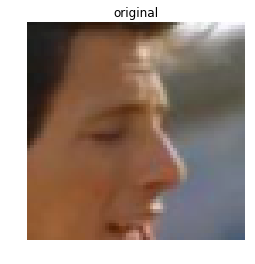

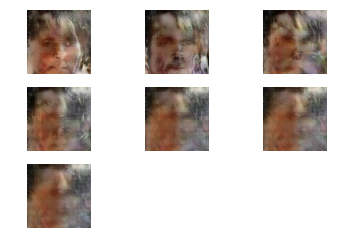

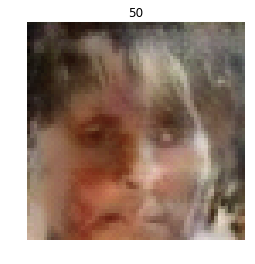

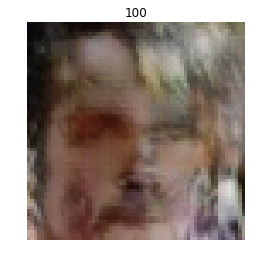

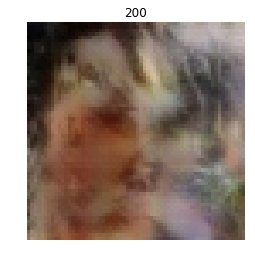

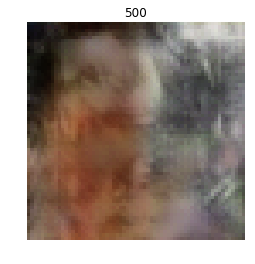

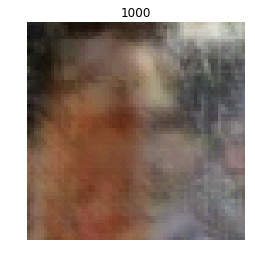

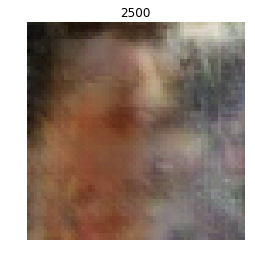

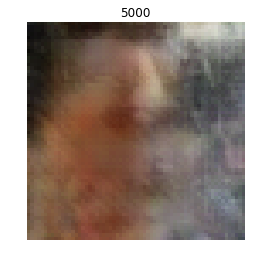

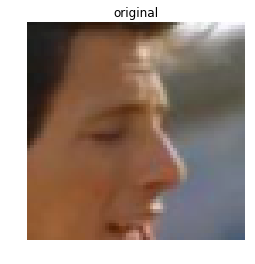

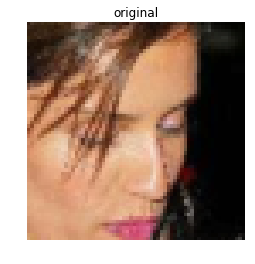

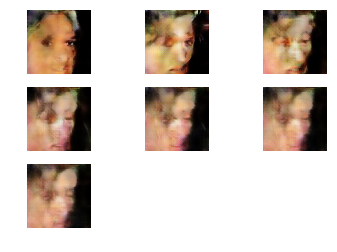

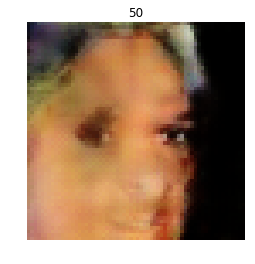

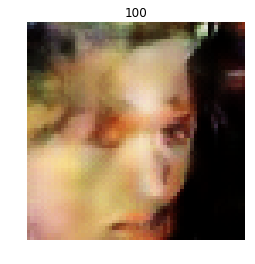

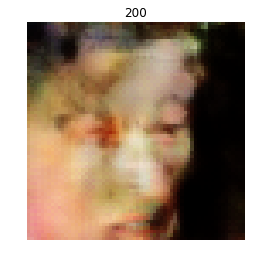

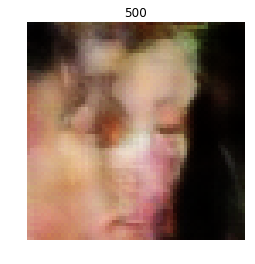

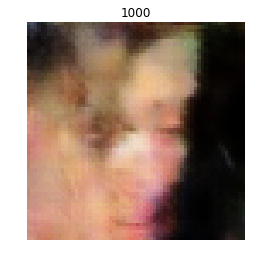

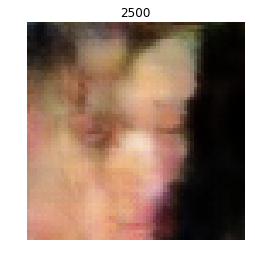

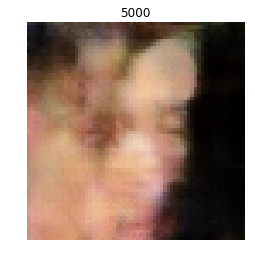

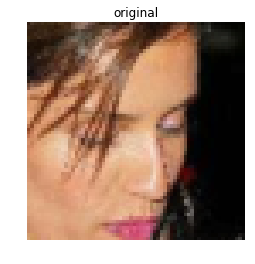

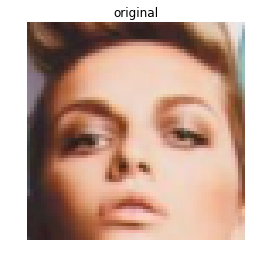

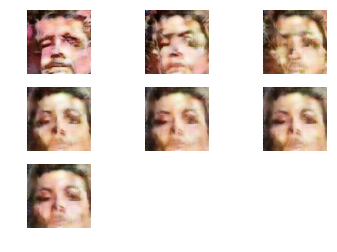

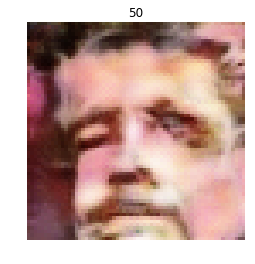

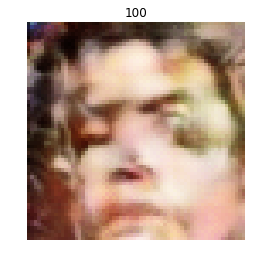

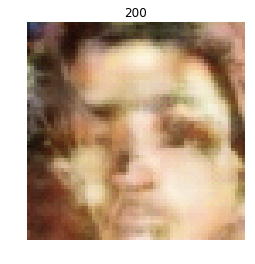

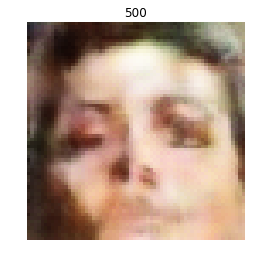

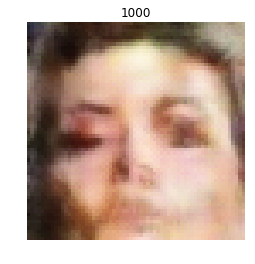

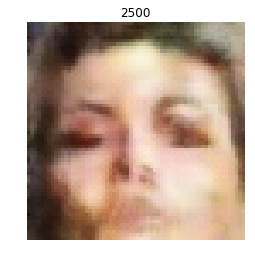

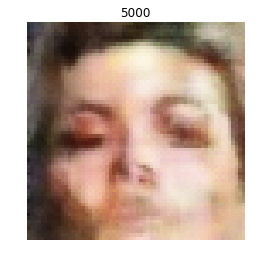

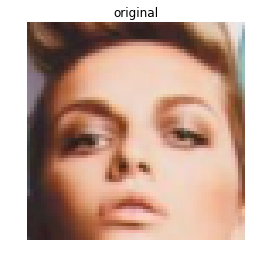

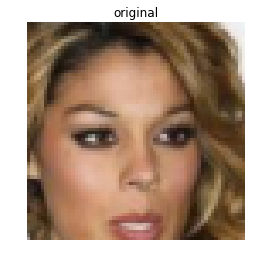

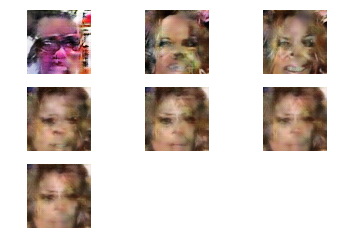

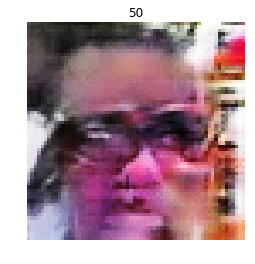

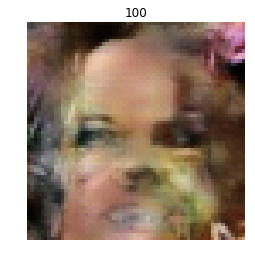

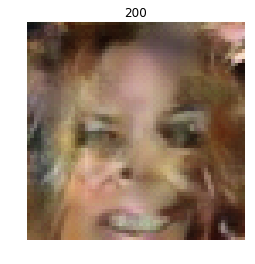

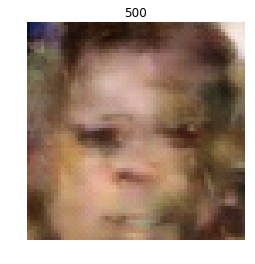

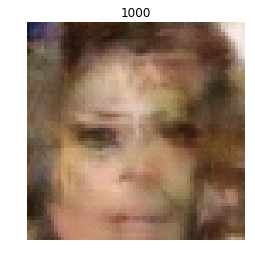

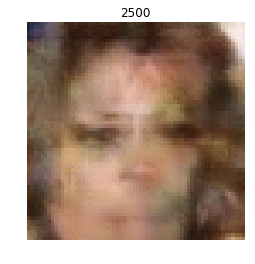

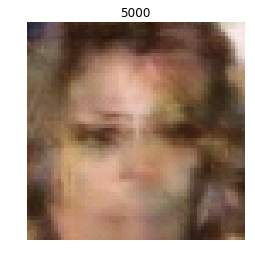

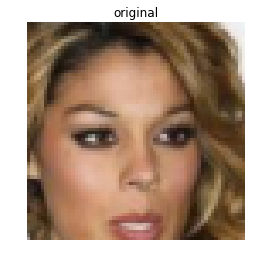

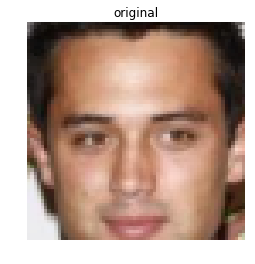

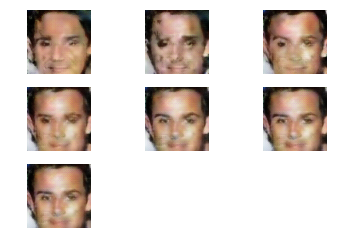

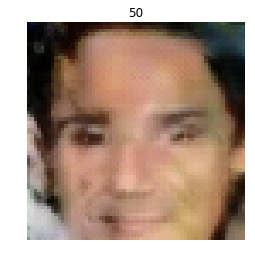

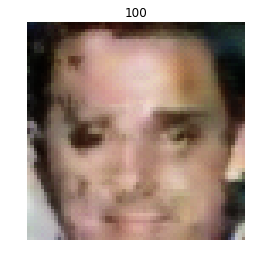

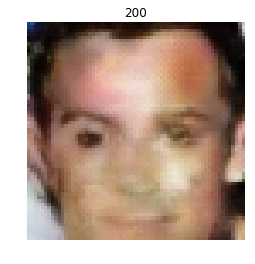

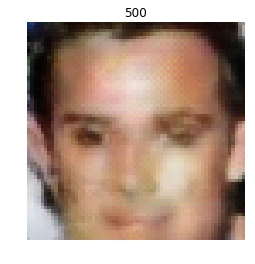

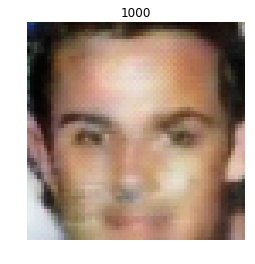

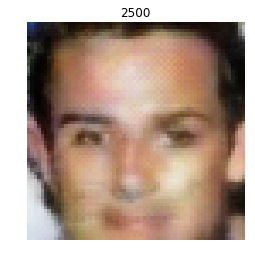

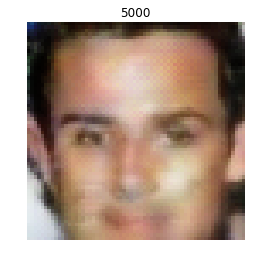

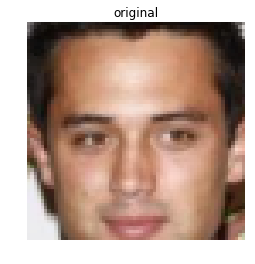

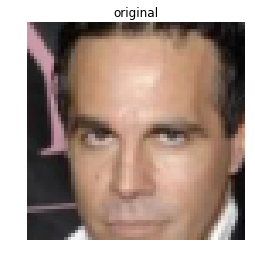

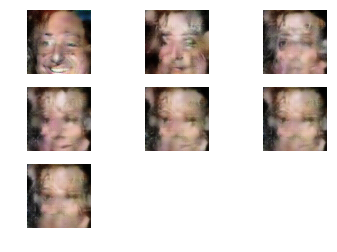

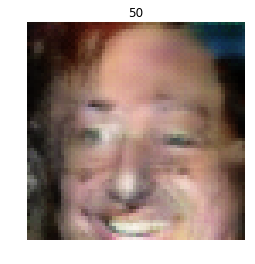

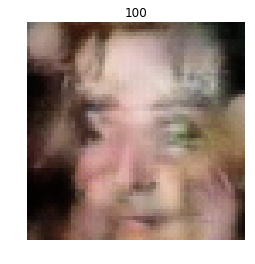

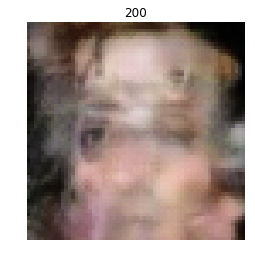

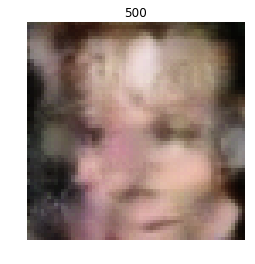

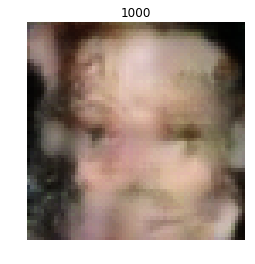

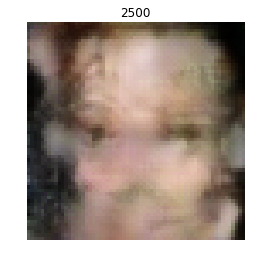

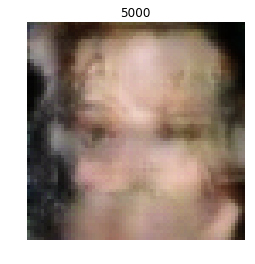

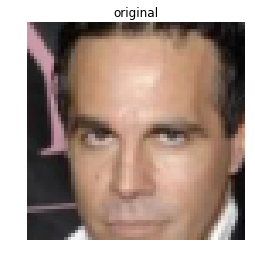

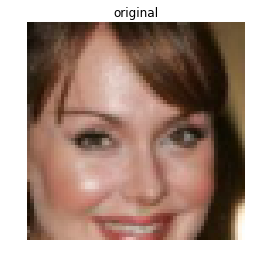

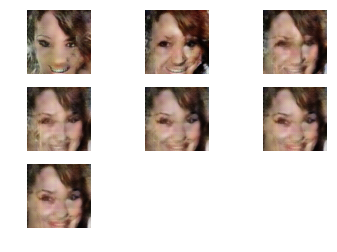

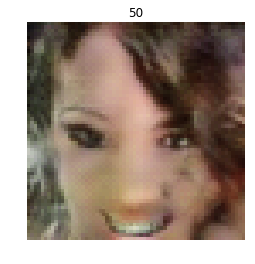

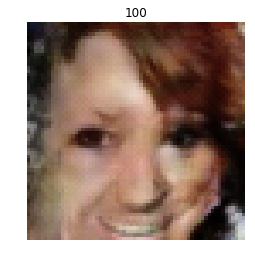

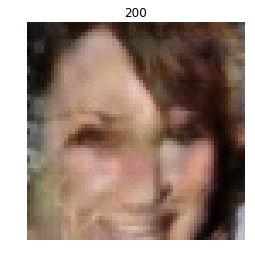

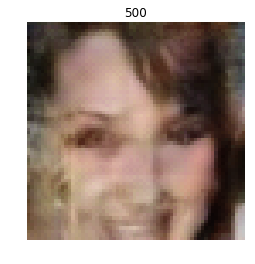

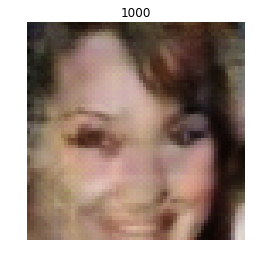

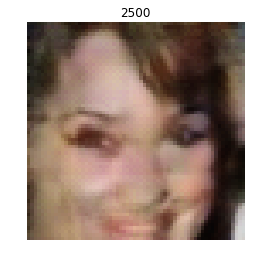

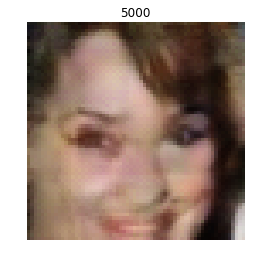

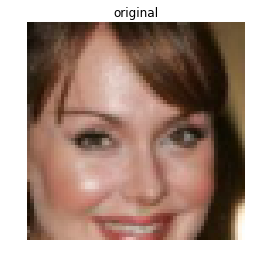

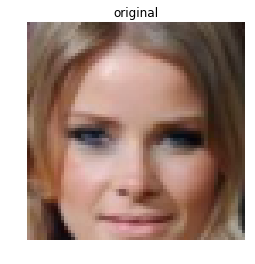

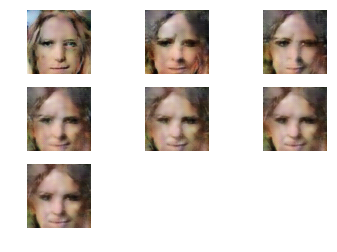

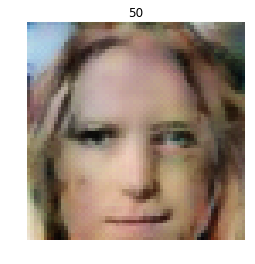

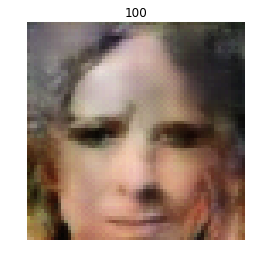

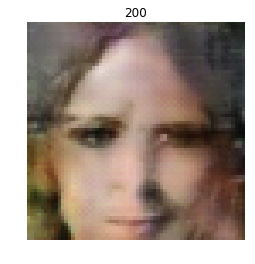

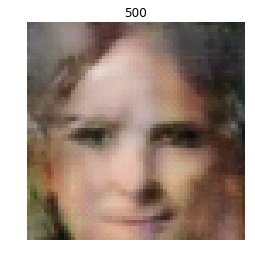

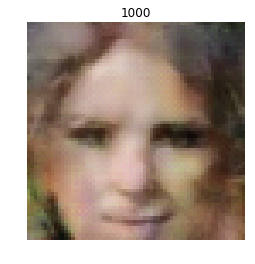

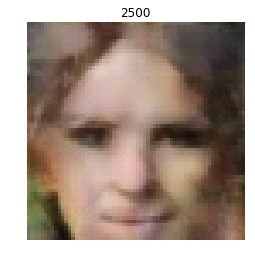

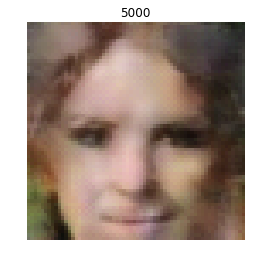

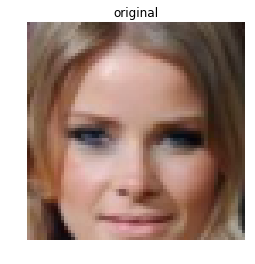

In [8]:
errors = []
for image_num in range(10):
    meas_err = []
    plt.figure()
    plt.title("original")
    plt.imshow((sample[image_num] + 1.0)/2.0) 
    plt.axis('off')

    fig = plt.figure()
    for i in range(len(compressed_images)):
        im = fig.add_subplot(3, len(compressed_images) / 2, i + 1)
        plt.imshow((compressed_images[i][image_num] + 1.0)/2.0)
        plt.axis('off')
        meas_err.append(np.sum((sample[image_num] - compressed_images[i][image_num])**2))
    #print(meas_err)
    errors.append(meas_err)

    for i in range(len(compressed_images)):
        plt.figure()
        plt.title(possible_ms[i])
        plt.imshow((compressed_images[i][image_num] + 1.0)/2.0)
        plt.axis('off')
        plt.figure()
    plt.title("original")
    plt.imshow((sample[image_num] + 1.0)/2.0) 
    plt.axis('off')

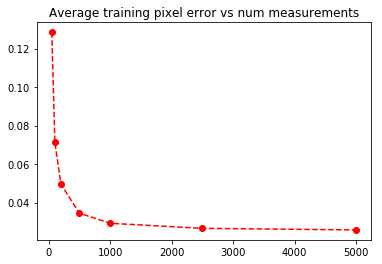

In [9]:
plt.plot(possible_ms, np.mean(errors, axis=0) / 12288.0, '--ro')
plt.title("Average training pixel error vs num measurements")
plt.show()